## Imports

In [1]:
import os
from typing import List, Callable
import warnings
from pathlib import Path
from PIL import Image

from skimage.feature import graycomatrix, graycoprops
from skimage.color import rgb2gray
from skimage.util import img_as_float
from skimage import feature
from sklearn.preprocessing import normalize
import cv2

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from tqdm.notebook import tqdm, trange
tqdm.pandas()

## Functions

In [2]:
def extract_color_features(
    image: np.ndarray, 
    hist=True
) -> pd.Series:
    """Extracts color features and optionally hist features
    
    Parameters
    ----------
    image : numpy.ndarray
        Image as numpy array.
    hist : bool
        Boolean flag whether to extract hist features from image.
    
    Returns
    -------
    pandas.Series
        Extracted features as pandas.Series.
    """
    flattened_img = image.reshape(-1, 3)
    
    # color features
    mean_color = np.mean(flattened_img, axis=0)
    std_color = np.std(flattened_img, axis=0)
    
    hist_r, hist_g, hist_b = [], [], []
    if hist:
        hist_r = np.histogram(flattened_img[:, 0], bins=256, range=[0, 256])[0]
        hist_g = np.histogram(flattened_img[:, 1], bins=256, range=[0, 256])[0]
        hist_b = np.histogram(flattened_img[:, 2], bins=256, range=[0, 256])[0]
    
    color_features = pd.Series(
        np.concatenate([mean_color, std_color, hist_r, hist_g, hist_b]), 
        index=['mean_red', 'mean_green', 'mean_blue', 'std_red', 'std_green', 'std_blue'] + \
              [f'hist_red_{i}' for i in range(256 if hist else 0)] + \
              [f'hist_green_{i}' for i in range(256 if hist else 0)] + \
              [f'hist_blue_{i}' for i in range(256 if hist else 0)]
    )    
    return color_features


def extract_textural_features(
    image: np.ndarray, 
    lbp=True, 
    normalize_features=False
) -> pd.Series:
    """Extracts textural features and optionally lbp (local binary pattern) features
    
    Parameters
    ----------
    image : numpy.ndarray
        Image as numpy array.
    lbp : bool
        Boolean flag whether to extract lbp features from image.
    
    Returns
    -------
    pandas.Series
        Extracted features as pandas.Series.
    """
    gray_img = rgb2gray(image)
    gray_img_uint = (gray_img * 255).astype(np.uint8)
    glcm = graycomatrix(gray_img_uint, [1], [0], 256, symmetric=True, normed=True)
    
    # texture features
    contrast = graycoprops(glcm, 'contrast').ravel()
    dissimilarity = graycoprops(glcm, 'dissimilarity').ravel()
    homogeneity = graycoprops(glcm, 'homogeneity').ravel()
    energy = graycoprops(glcm, 'energy').ravel()
    correlation = graycoprops(glcm, 'correlation').ravel()
    
    if lbp:
        lbp = feature.local_binary_pattern(gray_img, 8, 1, method='uniform')
        lbp_hist, _ = np.histogram(lbp, bins=np.arange(0, 8 + 3), range=(0, 8 + 2))
    else:
        lbp_hist = np.array([])
    
    texture_features = np.concatenate([contrast, dissimilarity, homogeneity, energy, correlation, lbp_hist])
    if normalize_features:
        texture_features = normalize([texture_features])[0]
        
    texture_features = pd.Series(
        texture_features, 
        index=['contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation'] + \
              [f'lbp_{i}' for i in range(len(lbp_hist))]
    )
    
    return texture_features


def extract_features(
    image: np.ndarray,
    hist: bool,
    lbp: bool,
    normalize_textural_features: bool
) -> pd.Series:
    """Extracts both textural and color features from image by given path.
    
    Parameters
    ----------
    image : numpy.ndarray
        Image as numpy array.
    hist : bool
        Boolean flag whether to extract hist features from image.
    lbp : bool
        Boolean flag whether to extract lbp features from image.
    normalize_textural_features : bool
        Boolean flag whether to perform normalization of textural features.
    
    Returns
    -------
    pandas.Series
        Extracted features as pandas.Series.
    """
    color_features = extract_color_features(
        image, 
        hist=hist
    )
    texture_features = extract_textural_features(
        image, 
        lbp=lbp, 
        normalize_features=normalize_textural_features
    )
    features = pd.concat([color_features, texture_features])
    
    return features

In [3]:
def get_image(path):
    img = cv2.imread(path,cv2.IMREAD_COLOR)
    return img_as_float(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

In [4]:
def split_image(image: np.ndarray, sample_size: int = 32) -> List[np.ndarray]:
    height, width = image.shape[:2]
    samples = []
    for y in range(0, height, sample_size):
        for x in range(0, width, sample_size):
            sample = image[y:y+sample_size, x:x+sample_size]
            samples.append(sample)
    return samples

In [5]:
from sklearn.model_selection import KFold

def cross_validate_model(
    model,
    X: pd.DataFrame,
    Y: pd.DataFrame,
    score_fns: List[Callable],
    score_average: str = 'weighted',
    n_folds: int = 5,
    iterations: int = 5
):
    metrics = {fn.__name__: [] for fn in score_fns}
    data = pd.concat([X.copy(), Y.copy()], axis=1)
    target = Y.columns[0]
    
    n_splits = 5
    kf = KFold(n_splits=n_folds)
    for _ in trange(5, desc='Cross validation'):
        shuffle = data.sample(frac=1).reset_index(drop=True)
        for train_index, test_index in tqdm(list(kf.split(shuffle)), desc='Splits evaluation', leave=False):
            model.fit(
                shuffle.iloc[train_index].drop(target, axis=1), 
                shuffle.iloc[train_index][target]
            )

            y_test = shuffle.iloc[test_index][target].to_numpy()
            y_pred = model.predict(shuffle.iloc[test_index].drop(target, axis=1))

            for fn in score_fns:
                metrics[fn.__name__].append(fn(y_test, y_pred, average=score_average))
    
    return metrics

## Global variables

In [6]:
DATA_DIR = Path(os.environ['PROJECT_DIR']) / 'data' / 'pigments'
IMAGE_SAMPLE_SIZE = 32
TRAIN_SET_SIZE = 0.8
TEST_SET_SIZE = 0.2
RANDOM_STATE = 42

## Data preprocessing

In [7]:
df = pd.DataFrame({'img_path': [path for path in DATA_DIR.rglob('*.jpg')]})
df['label'] = df['img_path'].apply(lambda path: path.stem)
df['image'] = df['img_path'].progress_apply(lambda path: get_image(path.as_posix()))

  0%|          | 0/176 [00:00<?, ?it/s]

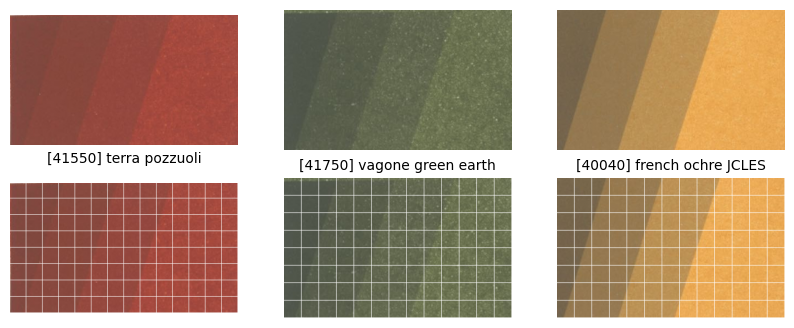

In [8]:
fig, ax = plt.subplots(2, 3, figsize=(10, 4))
for i, (_, row) in enumerate(df.sample(3, random_state=0).iterrows()):
    # crop image
    image = np.copy(row['image'])
    w, h = image.shape[:2]
    image = image[:w//IMAGE_SAMPLE_SIZE*IMAGE_SAMPLE_SIZE, :h//IMAGE_SAMPLE_SIZE*IMAGE_SAMPLE_SIZE, :]
    ax[0, i].imshow(image)

    # draw lines illustrating split samples
    image[IMAGE_SAMPLE_SIZE-1::IMAGE_SAMPLE_SIZE, :] = [1, 1, 1]
    image[:, IMAGE_SAMPLE_SIZE-1::IMAGE_SAMPLE_SIZE] = [1, 1, 1]
    ax[1, i].imshow(image)

    # plot settings
    ax[0, i].set_title(row['label'], {'fontsize': 10}, y=-0.2)
    ax[0, i].axis('off')
    ax[1, i].axis('off')

In [9]:
label_encoder = LabelEncoder()
df['label'] = label_encoder.fit_transform(df['label'])
df['sample'] = df['image'].progress_apply(lambda image: split_image(image, sample_size=IMAGE_SAMPLE_SIZE))

df.drop(['img_path', 'image'], axis=1, inplace=True)
df = df.explode('sample')

  0%|          | 0/176 [00:00<?, ?it/s]

In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22749 entries, 0 to 175
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   22749 non-null  int64 
 1   sample  22749 non-null  object
dtypes: int64(1), object(1)
memory usage: 533.2+ KB


In [11]:
warnings.simplefilter("ignore", UserWarning)

features = df['sample'].progress_apply(
    lambda sample: extract_features(
        image=sample,
        hist=False,
        lbp=False,
        normalize_textural_features=False
    )
)

# do not forget to reset warnings!
warnings.resetwarnings()

df = pd.concat([df, features], axis=1)

  0%|          | 0/22749 [00:00<?, ?it/s]

In [12]:
df.drop('sample', axis=1, inplace=True)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 22749 entries, 0 to 175
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   label          22749 non-null  int64  
 1   mean_red       22749 non-null  float64
 2   mean_green     22749 non-null  float64
 3   mean_blue      22749 non-null  float64
 4   std_red        22749 non-null  float64
 5   std_green      22749 non-null  float64
 6   std_blue       22749 non-null  float64
 7   contrast       22749 non-null  float64
 8   dissimilarity  22749 non-null  float64
 9   homogeneity    22749 non-null  float64
 10  energy         22749 non-null  float64
 11  correlation    22749 non-null  float64
dtypes: float64(11), int64(1)
memory usage: 2.3 MB


## Model training

In [14]:
from sklearn.metrics import precision_score, recall_score
from sklearn.ensemble import RandomForestClassifier

In [15]:
config = {
    'n_estimators': 100,
    'random_state': RANDOM_STATE
}

In [16]:
cross_validation_result = cross_validate_model(
    model=RandomForestClassifier(**config),
    X=df.drop(columns=['label']),
    Y=df[['label']],
    score_fns=[precision_score, recall_score],
    score_average='weighted',
    n_folds=5,
    iterations=5
)

Cross validation:   0%|          | 0/5 [00:00<?, ?it/s]

Splits evaluation:   0%|          | 0/5 [00:00<?, ?it/s]

Splits evaluation:   0%|          | 0/5 [00:00<?, ?it/s]

Splits evaluation:   0%|          | 0/5 [00:00<?, ?it/s]

Splits evaluation:   0%|          | 0/5 [00:00<?, ?it/s]

Splits evaluation:   0%|          | 0/5 [00:00<?, ?it/s]

In [17]:
avg_precision = np.mean(cross_validation_result['precision_score'])
avg_recall = np.mean(cross_validation_result['recall_score'])
print(f'{avg_precision = :.2f}\n{avg_recall = :.2f}')

avg_precision = 0.91
avg_recall = 0.91


In [18]:
from sklearn.ensemble import RandomForestClassifier

X_train, X_test, y_train, y_test = train_test_split(df.drop(columns=['label']), df['label'], test_size=0.2, random_state=RANDOM_STATE)

random_forest = RandomForestClassifier(**config)
random_forest.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [19]:
y_pred = random_forest.predict(X_test)
eval_result = classification_report(
    label_encoder.inverse_transform(y_test), 
    label_encoder.inverse_transform(y_pred)
)
print(eval_result)

                                                          precision    recall  f1-score   support

                                [10010] smalt, very fine       0.90      1.00      0.95        26
                        [10200] azurite natural standard       1.00      1.00      1.00        24
                   [10550] lapis lazuli bright pure blue       1.00      1.00      1.00        30
                           [17000] jarosite, from cyprus       0.88      0.93      0.90        30
                    [17050] natural sienna, monte amiata       1.00      0.88      0.94        25
                        [17400] green earth, from cyprus       0.80      0.80      0.80        20
                        [17410] bluish green earth, from       0.76      0.65      0.70        20
                       [21010] cadmium yellow lemon no.1       0.86      0.95      0.90        20
                 [21020] cadmium yellow no.2, very light       1.00      1.00      1.00        35
                   